In [23]:
## Import relevant libraries
import sys
import os
import shutil
from natsort import natsorted  # For natural sorting
sys.path.append('../../activedrops')

## Including ourselves
import quadrop as qd
# qd.set_plotting_style()


import glob
import imageio
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


let's try to make the 3d plot with time vs protein concentration vs velocity

In [24]:
import os
import numpy as np
import pandas as pd
import imageio.v2 as imageio
from scipy.ndimage import gaussian_filter1d
import glob

def save_fluorescence_data(data_path, conditions, subconditions, channel, time_intervals, min_frame, max_frame,
                           skip_frames=1, line_slope=1, line_intercept=0, timescale="h", averaged=True, subtract_first_datapoint=True):
    """
    Computes and saves the average fluorescence intensity and concentration over time for a given set of images across
    multiple conditions into a Pandas DataFrame, and then saves it as a CSV file. Averages across all subconditions for each condition.

    Parameters:
    - data_path (str): Base path where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - channel (str): Channel name.
    - time_intervals (list of int): List of time intervals between frames in seconds, one for each condition.
    - min_frame (int): Minimum frame number to process.
    - max_frame (int): Maximum frame number to process.
    """
    all_data = []

    # Define conversion factor based on the timescale
    time_conversion_factor = 1 / 3600 if timescale == "h" else 1 / 60

    for condition_idx, (condition, time_interval) in enumerate(zip(conditions, time_intervals)):
        current_time_interval = time_interval * time_conversion_factor  # Convert time_interval to the correct timescale
        condition_data = []

        for sub_idx, subcondition in enumerate(subconditions):
            directory_path = os.path.join(data_path, condition, subcondition, "original")

            if channel == "cy5":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*cy5*.tif")))[min_frame:max_frame:skip_frames]
            elif channel == "gfp":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*gfp*.tif")))[min_frame:max_frame:skip_frames]

            intensities = []
            for image_file in image_files:
                img = imageio.imread(image_file) / 2**16  # Normalize to 16-bit

                # Select ROI and compute mean intensity
                mean_intensity = np.mean(img[750:1250, 750:1250]) - np.min(img)
                intensities.append(mean_intensity)

                

            concentrations = [(intensity - line_intercept) / line_slope for intensity in intensities]
            concentrations = gaussian_filter1d(concentrations, sigma=2)

            if subtract_first_datapoint:
                concentrations = np.array(concentrations) - concentrations[0]

            frames = [i * skip_frames for i in range(len(concentrations))]
            data = pd.DataFrame({'frame': frames, 'Intensity': intensities, 'Concentration': concentrations})
       

            condition_data.append(data)

        if averaged:
            # Compute the average across subconditions
            avg_data = pd.concat(condition_data).groupby('frame').mean().reset_index()
            avg_data['Condition_Subcondition'] = f"{condition}_avg"
            all_data.append(avg_data)

    result_df = pd.concat(all_data, ignore_index=True)
    output_csv_path = os.path.join(data_path, f"{channel}_averaged_fluorescence_data.csv")
    result_df.to_csv(output_csv_path, index=False)
    return output_csv_path



load PIV file

In [25]:
file = "../../data/K401_Kif3-piv/k401/rep1/dataframes_PIV/mean_values.csv"

minframe_k401 = 50

# open the file
k401_piv = pd.read_csv(file, ).iloc[minframe_k401:,:]
k401_piv = k401_piv.reset_index(drop=True)
k401_piv['frame'] = k401_piv['frame'] - k401_piv['frame'].iloc[0]


k401_piv

,frame,x [m]_mean,y [m]_mean,u [m/s]_mean,v [m/s]_mean,data type [-]_mean,vorticity [1/s]_mean,velocity magnitude [m/s]_mean,divergence [1/s]_mean,dcev [1]_mean,shear [1/s]_mean,strain [1/s]_mean,vector direction [degrees]_mean,correlation length [m]_mean,power [W]_mean
0,0,0.001402,0.001398,1.224737e-09,-5.853105e-10,1.0,-1.036250e-07,2.149760e-09,1.323014e-06,2.577741,-1.463648e-09,-2.142165e-07,-25.943633,0.000293,1.347197e-22
1,1,0.001403,0.001397,1.164931e-09,-3.700454e-10,1.0,-3.837995e-07,2.072673e-09,1.554072e-06,2.889696,1.792895e-07,9.924506e-08,-22.712506,0.000260,1.588093e-22
2,2,0.001403,0.001398,1.408422e-09,-2.349813e-10,1.0,5.920449e-07,2.250061e-09,1.664083e-06,3.212434,3.442890e-07,2.808551e-07,-13.428827,0.000266,1.788366e-22
3,3,0.001403,0.001399,1.418673e-09,-1.948523e-10,1.0,-2.623075e-07,2.210801e-09,1.933343e-06,2.300324,6.538884e-07,2.126675e-07,-11.538544,0.000271,1.661771e-22
4,4,0.001403,0.001396,1.243179e-09,-2.623373e-10,1.0,-2.058924e-08,2.089139e-09,1.901175e-06,2.612428,5.866202e-07,-2.093692e-07,-16.800644,0.000271,1.484186e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,628,0.001398,0.001412,3.734588e-10,-1.095270e-10,1.0,1.483355e-07,1.104787e-09,-1.961540e-07,1.804152,-4.142836e-07,3.858349e-07,-15.886977,0.000040,1.916343e-21
629,629,0.001399,0.001412,1.749555e-10,-2.003669e-10,1.0,-3.852272e-07,1.019131e-09,3.873840e-07,1.177091,2.363729e-07,2.870526e-07,-37.228867,0.000037,1.899973e-21
630,630,0.001399,0.001412,4.426674e-10,-4.687474e-11,1.0,-7.878161e-07,1.067406e-09,-5.858149e-08,2.066637,7.614709e-07,1.775444e-07,-8.232139,0.000040,1.765643e-21
631,631,0.001401,0.001412,-4.788484e-11,-2.125379e-10,1.0,-2.918865e-07,9.809529e-10,-4.938627e-08,2.212358,9.356893e-08,2.096722e-07,-51.849146,0.000033,2.149452e-21


In [26]:
file = "../../data/K401_Kif3-piv/kif3/rep1/dataframes_PIV/mean_values.csv"

minframe_kif3 = 0

# open the file
kif3_piv = pd.read_csv(file, ).iloc[minframe_kif3:,:]
kif3_piv = kif3_piv.reset_index(drop=True)
kif3_piv['frame'] = kif3_piv['frame'] - kif3_piv['frame'].iloc[0]

# make sure to have the correct velocity magnitude for the kif3 data by subtracting the last velocity value from all values
kif3_piv['velocity_magnitude'] = kif3_piv['velocity magnitude [m/s]_mean'] - kif3_piv['velocity magnitude [m/s]_mean'].iloc[-1]


generate fluorescence or concentration vs time plot

In [27]:
data_path = "../../data/temperatures-k401_kif3_kif5/"

# let's declare the variable "conditions" to the sorted list of subdirectories from data_path
conditions = natsorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))])

# let's declare the variable "subconditions" to the sorted list of subdirectories from the first condition
subconditions = natsorted([f for f in os.listdir(os.path.join(data_path, conditions[0])) if os.path.isdir(os.path.join(data_path, conditions[0], f))])

conditions, subconditions

(['k401-20C', 'k401-30C', 'kif3-20C', 'kif3-30C', 'kif5-20C', 'kif5-30C'],
 ['Pos0'])

In [28]:
conditions = ['k401-20C', 'kif3-20C']

In [29]:
time_intervals = time_intervals = [180, 60]

save_fluorescence_data(
    data_path, 
    conditions, 
    subconditions, 
    channel='gfp', 
    time_intervals=time_intervals,   
    min_frame=0, 
    max_frame=None, 
    skip_frames=1, 
    line_slope=0.00042, 
    line_intercept=0.00159,
    timescale="h", 
    averaged=True, 
    subtract_first_datapoint=False
    )


'../../data/temperatures-k401_kif3_kif5/gfp_averaged_fluorescence_data.csv'

In [30]:
k401_fluorescence = pd.read_csv("../../data/temperatures-k401_kif3_kif5/gfp_averaged_fluorescence_data.csv")

# slice the dataframe to only get the part of the dataframe that has "k401-20C_avg" in the "Condition_Subcondition" column
k401_fluorescence = k401_fluorescence[k401_fluorescence["Condition_Subcondition"] == "k401-20C_avg"]

# same for kif3
kif3_fluorescence = pd.read_csv("../../data/temperatures-k401_kif3_kif5/gfp_averaged_fluorescence_data.csv")
kif3_fluorescence = kif3_fluorescence[kif3_fluorescence["Condition_Subcondition"] == "kif3-20C_avg"]


In [31]:
k401_fluorescence

,frame,Intensity,Concentration,Condition_Subcondition
0,0,0.001914,0.943970,k401-20C_avg
1,1,0.002143,0.927767,k401-20C_avg
2,2,0.001930,0.893742,k401-20C_avg
3,3,0.001913,0.847750,k401-20C_avg
4,4,0.002010,0.807474,k401-20C_avg
...,...,...,...,...
466,466,0.009499,18.487155,k401-20C_avg
467,467,0.009403,18.584536,k401-20C_avg
468,468,0.009354,18.657262,k401-20C_avg
469,469,0.009658,18.699330,k401-20C_avg


In [32]:
kif3_fluorescence

,frame,Intensity,Concentration,Condition_Subcondition
471,0,0.001853,0.446222,kif3-20C_avg
472,1,0.001806,0.406027,kif3-20C_avg
473,2,0.001622,0.348316,kif3-20C_avg
474,3,0.001768,0.303599,kif3-20C_avg
475,4,0.001614,0.292901,kif3-20C_avg
...,...,...,...,...
1570,1099,0.008270,15.953090,kif3-20C_avg
1571,1100,0.008197,15.864264,kif3-20C_avg
1572,1101,0.008096,15.813460,kif3-20C_avg
1573,1102,0.008229,15.803334,kif3-20C_avg


Now let's merge the PIV and fluorescence data

In [33]:
# now we can merge the PIV and fluorescence dataframes
k401 = pd.merge(k401_piv, k401_fluorescence, on='frame')
k401["work [J]"] = k401["power [W]_mean"].cumsum()

# now just turn the 'frame' column into time_sec by taking those units as seconds
k401['time_sec'] = k401['frame'] * time_intervals[0]

# add time in minutes
k401['time_min'] = k401['time_sec'] / 60

# add time in hours
k401['time_h'] = k401['time_sec'] / 3600

k401

k401

,frame,x [m]_mean,y [m]_mean,u [m/s]_mean,v [m/s]_mean,data type [-]_mean,vorticity [1/s]_mean,velocity magnitude [m/s]_mean,divergence [1/s]_mean,dcev [1]_mean,...,vector direction [degrees]_mean,correlation length [m]_mean,power [W]_mean,Intensity,Concentration,Condition_Subcondition,work [J],time_sec,time_min,time_h
0,0,0.001402,0.001398,1.224737e-09,-5.853105e-10,1.0,-1.036250e-07,2.149760e-09,1.323014e-06,2.577741,...,-25.943633,0.000293,1.347197e-22,0.001914,0.943970,k401-20C_avg,1.347197e-22,0,0.0,0.00
1,1,0.001403,0.001397,1.164931e-09,-3.700454e-10,1.0,-3.837995e-07,2.072673e-09,1.554072e-06,2.889696,...,-22.712506,0.000260,1.588093e-22,0.002143,0.927767,k401-20C_avg,2.935290e-22,180,3.0,0.05
2,2,0.001403,0.001398,1.408422e-09,-2.349813e-10,1.0,5.920449e-07,2.250061e-09,1.664083e-06,3.212434,...,-13.428827,0.000266,1.788366e-22,0.001930,0.893742,k401-20C_avg,4.723656e-22,360,6.0,0.10
3,3,0.001403,0.001399,1.418673e-09,-1.948523e-10,1.0,-2.623075e-07,2.210801e-09,1.933343e-06,2.300324,...,-11.538544,0.000271,1.661771e-22,0.001913,0.847750,k401-20C_avg,6.385428e-22,540,9.0,0.15
4,4,0.001403,0.001396,1.243179e-09,-2.623373e-10,1.0,-2.058924e-08,2.089139e-09,1.901175e-06,2.612428,...,-16.800644,0.000271,1.484186e-22,0.002010,0.807474,k401-20C_avg,7.869614e-22,720,12.0,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,466,0.001395,0.001413,3.273166e-10,4.025360e-10,1.0,-7.097881e-07,2.138816e-09,-7.838675e-07,3.064620,...,10.301585,0.000201,2.821392e-22,0.009499,18.487155,k401-20C_avg,7.652403e-19,83880,1398.0,23.30
467,467,0.001395,0.001413,8.547357e-11,6.628024e-10,1.0,-9.778689e-07,2.222578e-09,6.212967e-08,2.673036,...,27.845333,0.000212,2.739817e-22,0.009403,18.584536,k401-20C_avg,7.655143e-19,84060,1401.0,23.35
468,468,0.001397,0.001413,3.121125e-10,4.123370e-10,1.0,-7.540031e-07,2.106688e-09,3.660570e-07,3.074631,...,11.817988,0.000205,2.645139e-22,0.009354,18.657262,k401-20C_avg,7.657788e-19,84240,1404.0,23.40
469,469,0.001395,0.001413,1.717362e-10,4.607933e-10,1.0,-9.337186e-07,2.112085e-09,-6.721424e-07,2.183831,...,8.169507,0.000190,3.081964e-22,0.009658,18.699330,k401-20C_avg,7.660870e-19,84420,1407.0,23.45


In [34]:
# now we can merge the PIV and fluorescence dataframes
kif3 = pd.merge(kif3_piv, kif3_fluorescence, on='frame')
kif3["work [J]"] = kif3["power [W]_mean"].cumsum()

# now just turn the 'frame' column into time_sec by taking those units as seconds
kif3['time_sec'] = kif3['frame'] * time_intervals[1]

# add time in minutes
kif3['time_min'] = kif3['time_sec'] / 60

# add time in hours
kif3['time_h'] = kif3['time_sec'] / 3600

kif3

kif3

,frame,x [m]_mean,y [m]_mean,u [m/s]_mean,v [m/s]_mean,data type [-]_mean,vorticity [1/s]_mean,velocity magnitude [m/s]_mean,divergence [1/s]_mean,dcev [1]_mean,...,correlation length [m]_mean,power [W]_mean,velocity_magnitude,Intensity,Concentration,Condition_Subcondition,work [J],time_sec,time_min,time_h
0,0,0.001404,0.001355,1.695753e-07,2.242387e-07,1.0,0.000065,4.202324e-07,0.000612,7.940178,...,0.000331,4.034534e-18,3.969945e-07,0.001853,0.446222,kif3-20C_avg,4.034534e-18,0,0.0,0.000000
1,1,0.001407,0.001355,2.173497e-08,2.362099e-07,1.0,0.000070,3.736369e-07,0.000456,7.895405,...,0.000379,2.425681e-18,3.503990e-07,0.001806,0.406027,kif3-20C_avg,6.460215e-18,60,1.0,0.016667
2,2,0.001408,0.001354,-3.542448e-08,2.640178e-07,1.0,0.000060,3.816198e-07,0.000469,7.025261,...,0.000365,2.729097e-18,3.583819e-07,0.001622,0.348316,kif3-20C_avg,9.189312e-18,120,2.0,0.033333
3,3,0.001407,0.001355,3.249196e-08,2.883236e-07,1.0,0.000022,4.112234e-07,0.000497,7.513069,...,0.000348,3.486371e-18,3.879855e-07,0.001768,0.303599,kif3-20C_avg,1.267568e-17,180,3.0,0.050000
4,4,0.001407,0.001355,1.110971e-08,2.852295e-07,1.0,-0.000026,3.982692e-07,0.000474,5.463114,...,0.000356,3.128947e-18,3.750313e-07,0.001614,0.292901,kif3-20C_avg,1.580463e-17,240,4.0,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,1099,0.001429,0.001391,-9.148744e-09,1.987673e-09,1.0,-0.000008,3.841443e-08,0.000008,3.314029,...,0.000145,1.746983e-19,1.517650e-08,0.008270,15.953090,kif3-20C_avg,1.168131e-14,65940,1099.0,18.316667
1100,1100,0.001430,0.001392,-1.050189e-08,3.783920e-09,1.0,-0.000014,3.771282e-08,0.000011,5.676253,...,0.000140,1.823743e-19,1.447489e-08,0.008197,15.864264,kif3-20C_avg,1.168149e-14,66000,1100.0,18.333333
1101,1101,0.001428,0.001392,1.072731e-09,-1.257278e-09,1.0,-0.000006,3.848243e-08,0.000003,4.519112,...,0.000123,2.463865e-19,1.524450e-08,0.008096,15.813460,kif3-20C_avg,1.168174e-14,66060,1101.0,18.350000
1102,1102,0.001429,0.001393,-1.070166e-08,4.516830e-09,1.0,-0.000005,3.829615e-08,0.000015,3.274211,...,0.000120,2.538712e-19,1.505822e-08,0.008229,15.803334,kif3-20C_avg,1.168199e-14,66120,1102.0,18.366667


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


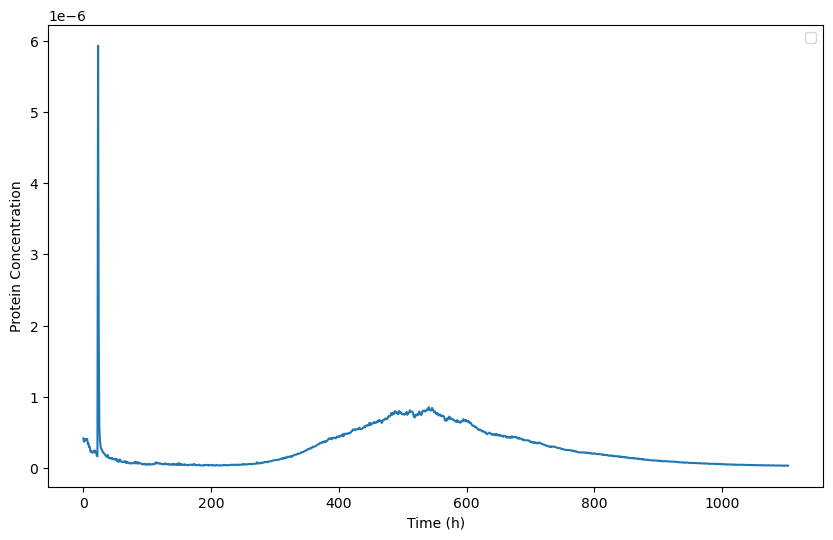

In [35]:
# now let's plot protein_concentration vs time_sec
plt.figure(figsize=(10, 6))
plt.plot(kif3['time_min'], kif3['velocity magnitude [m/s]_mean'], )
plt.xlabel('Time (h)')
plt.ylabel('Protein Concentration')
plt.legend()
plt.show()

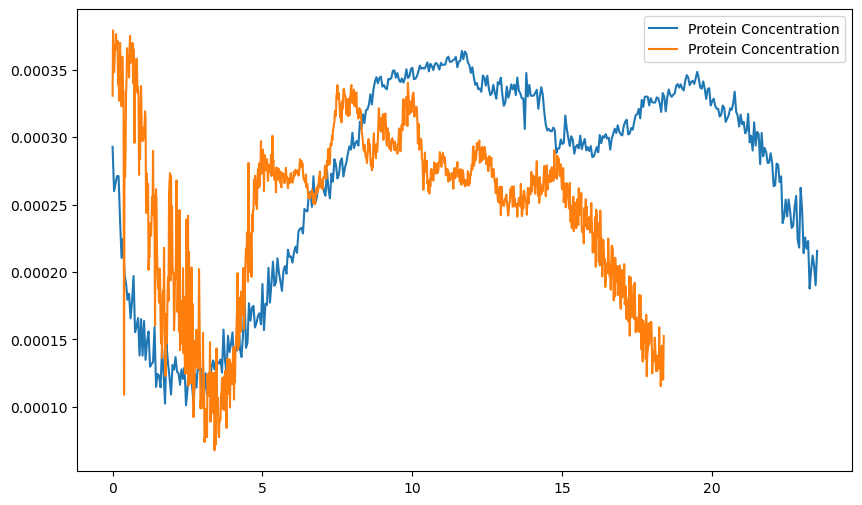

In [36]:
# now let's plot protein_concentration vs time_sec
plt.figure(figsize=(10, 6))
plt.plot(k401['time_h'], k401['correlation length [m]_mean'], label='Protein Concentration')
plt.plot(kif3['time_h'], kif3['correlation length [m]_mean'], label='Protein Concentration')
# plt.xlabel('Time (h)')
# plt.ylabel('Protein Concentration')
plt.legend()
plt.show()

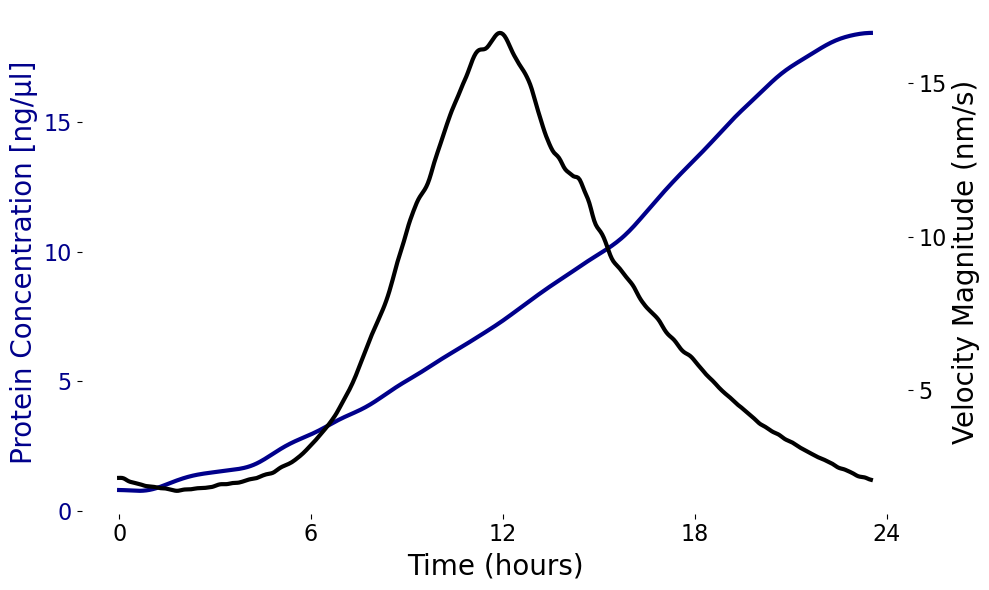

In [37]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

# Assuming df_merged is already loaded and contains 'time_sec', 'Concentration', and 'velocity magnitude [m/s]_mean'

# Applying a Gaussian filter with sigma = 2 to the data for smoothing
smoothed_concentration = gaussian_filter1d(k401['Concentration'], sigma=10)
smoothed_velocity = gaussian_filter1d(k401['velocity magnitude [m/s]_mean'], sigma=2)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Settings for larger fonts
label_font_size = 20  # Font size for labels
title_font_size = 20  # Font size for titles
tick_font_size = 16   # Font size for tick labels

# Plotting protein concentration
color = 'darkblue'  # Color for protein concentration
ax1.set_xlabel('Time (hours)', fontsize=label_font_size)
ax1.set_ylabel('Protein Concentration [ng/µl]', color=color, fontsize=label_font_size)
ax1.plot(k401['time_sec'] / 3600, smoothed_concentration, color=color, linewidth=3)  # Thicker line with Gaussian smoothing
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
ax1.tick_params(axis='x', labelsize=tick_font_size)  # Set font size for x-axis tick labels
ax1.xaxis.set_major_locator(MaxNLocator(5))  # Limit the number of x-axis ticks to 5
ax1.yaxis.set_major_locator(MaxNLocator(4))  # Limit the number of y-axis ticks to 5

# Setting spines to be invisible or a lighter color
for spine in ax1.spines.values():
    spine.set_visible(False)  # Make spines invisible

# Creating a second y-axis for velocity magnitude
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'black'  # Dark red color for velocity magnitude
ax2.set_ylabel('Velocity Magnitude (nm/s)', color=color, fontsize=label_font_size)
ax2.plot(k401['time_sec'] / 3600, smoothed_velocity * 1E9, color=color, linewidth=3)  # Thicker line with Gaussian smoothing
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
ax2.yaxis.set_major_locator(MaxNLocator(4))  # Limit the number of y-axis ticks to 5

# Optionally, also adjust the spines for ax2 if needed
for spine in ax2.spines.values():
    spine.set_visible(False)  # Make spines invisible

fig.tight_layout()  # Adjust layout to make sure everything fits and labels are not clipped

# Save the figure with 300 dpi
plt.savefig('plot.png', dpi=500)
plt.show()


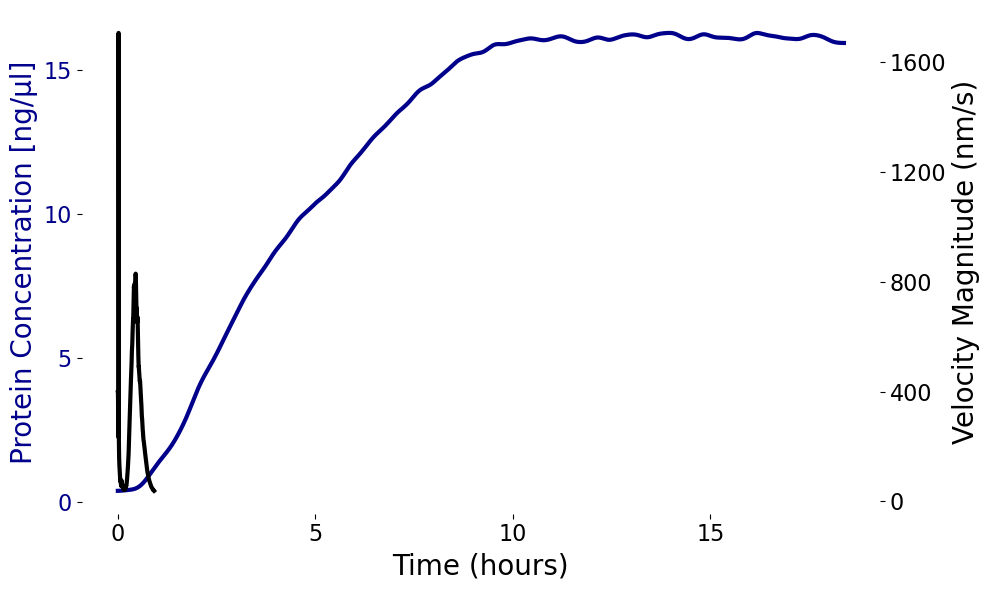

In [38]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

# Assuming df_merged is already loaded and contains 'time_sec', 'Concentration', and 'velocity magnitude [m/s]_mean'

# Applying a Gaussian filter with sigma = 2 to the data for smoothing
smoothed_concentration = gaussian_filter1d(kif3['Concentration'], sigma=10)
smoothed_velocity = gaussian_filter1d(kif3['velocity magnitude [m/s]_mean'], sigma=2)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Settings for larger fonts
label_font_size = 20  # Font size for labels
title_font_size = 20  # Font size for titles
tick_font_size = 16   # Font size for tick labels

# Plotting protein concentration
color = 'darkblue'  # Color for protein concentration
ax1.set_xlabel('Time (hours)', fontsize=label_font_size)
ax1.set_ylabel('Protein Concentration [ng/µl]', color=color, fontsize=label_font_size)
ax1.plot(kif3['time_h'], smoothed_concentration, color=color, linewidth=3)  # Thicker line with Gaussian smoothing
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
ax1.tick_params(axis='x', labelsize=tick_font_size)  # Set font size for x-axis tick labels
ax1.xaxis.set_major_locator(MaxNLocator(5))  # Limit the number of x-axis ticks to 5
ax1.yaxis.set_major_locator(MaxNLocator(4))  # Limit the number of y-axis ticks to 5

# Setting spines to be invisible or a lighter color
for spine in ax1.spines.values():
    spine.set_visible(False)  # Make spines invisible

# Creating a second y-axis for velocity magnitude
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'black'  # Dark red color for velocity magnitude
ax2.set_ylabel('Velocity Magnitude (nm/s)', color=color, fontsize=label_font_size)
ax2.plot(kif3['time_h'] / 20, smoothed_velocity * 1E9, color=color, linewidth=3)  # Thicker line with Gaussian smoothing
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
ax2.yaxis.set_major_locator(MaxNLocator(5))  # Limit the number of y-axis ticks to 5

# Optionally, also adjust the spines for ax2 if needed
for spine in ax2.spines.values():
    spine.set_visible(False)  # Make spines invisible

fig.tight_layout()  # Adjust layout to make sure everything fits and labels are not clipped

# Save the figure with 300 dpi
plt.savefig('plot.png', dpi=500)
plt.show()


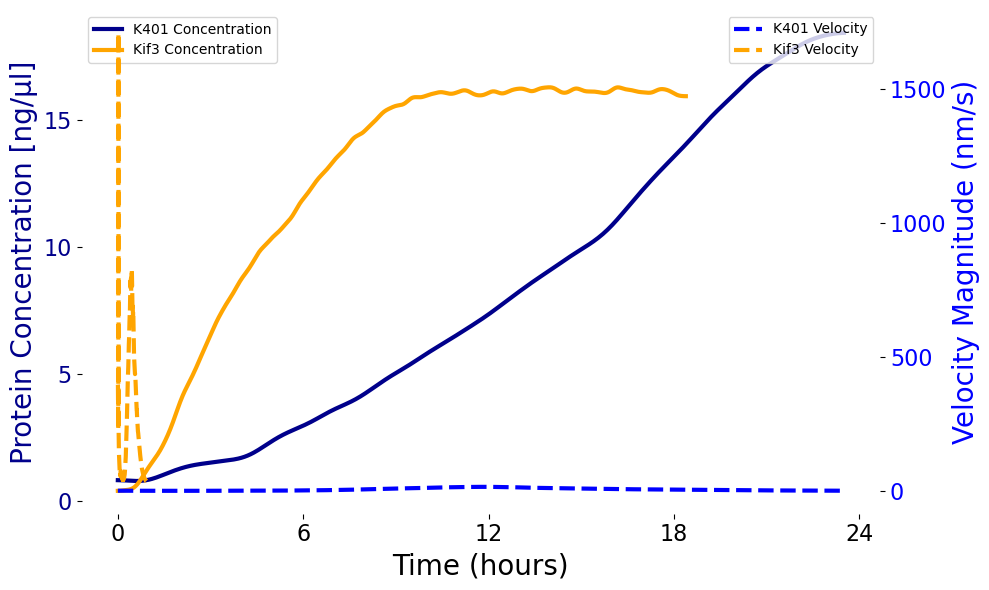

In [39]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

# Define a function to set up the plot
def setup_plot(ax, xlabel, ylabel, color, tick_font_size, y_locator):
    ax.set_xlabel(xlabel, fontsize=label_font_size)
    ax.set_ylabel(ylabel, color=color, fontsize=label_font_size)
    ax.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
    ax.tick_params(axis='x', labelsize=tick_font_size)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(y_locator))

    for spine in ax.spines.values():
        spine.set_visible(False)

# Assuming k401 and kif3 dataframes are loaded with time, concentration, and velocity data

# Applying Gaussian filters to smooth the data
smoothed_concentration_k401 = gaussian_filter1d(k401['Concentration'], sigma=10)
smoothed_velocity_k401 = gaussian_filter1d(k401['velocity magnitude [m/s]_mean'], sigma=2)

smoothed_concentration_kif3 = gaussian_filter1d(kif3['Concentration'], sigma=10)
smoothed_velocity_kif3 = gaussian_filter1d(kif3['velocity magnitude [m/s]_mean'], sigma=2)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Settings for larger fonts
label_font_size = 20  # Font size for labels
tick_font_size = 16   # Font size for tick labels

# Plotting protein concentration for k401
color = 'darkblue'
setup_plot(ax1, 'Time (hours)', 'Protein Concentration [ng/µl]', color, tick_font_size, 4)
ax1.plot(k401['time_sec'] / 3600, smoothed_concentration_k401, color=color, label='K401 Concentration', linewidth=3)

# Plotting protein concentration for kif3
color = 'orange'
ax1.plot(kif3['time_sec'] / 3600, smoothed_concentration_kif3, color=color, label='Kif3 Concentration', linewidth=3)

# Creating a second y-axis for velocity magnitude for k401
ax2 = ax1.twinx()
color = 'blue'
setup_plot(ax2, 'Time (hours)', 'Velocity Magnitude (nm/s)', color, tick_font_size, 4)
ax2.plot(k401['time_h'], smoothed_velocity_k401 * 1E9, color=color, label='K401 Velocity', linewidth=3, linestyle='--')

# Creating a second y-axis for velocity magnitude for kif3, using the same ax2
color = 'orange'
ax2.plot(kif3['time_h'] / 20, smoothed_velocity_kif3 * 1E9, color=color, label='Kif3 Velocity', linewidth=3, linestyle='--')

# Adding a legend to the first axis which will include both concentration and velocity information
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()  # Adjust layout to make sure everything fits and labels are not clipped
plt.savefig('combined_plot.png', dpi=500)  # Save the figure with 500 dpi
plt.show()


In [40]:
# subtract the difference between the last ['velocity magnitude [m/s]_mean'] of kif and k401 from kif3['velocity magnitude [m/s]_mean']
kif3['velocity magnitude [m/s]_mean'] = kif3['velocity magnitude [m/s]_mean'] - (kif3['velocity magnitude [m/s]_mean'].iloc[-1] - k401['velocity magnitude [m/s]_mean'].iloc[-1])

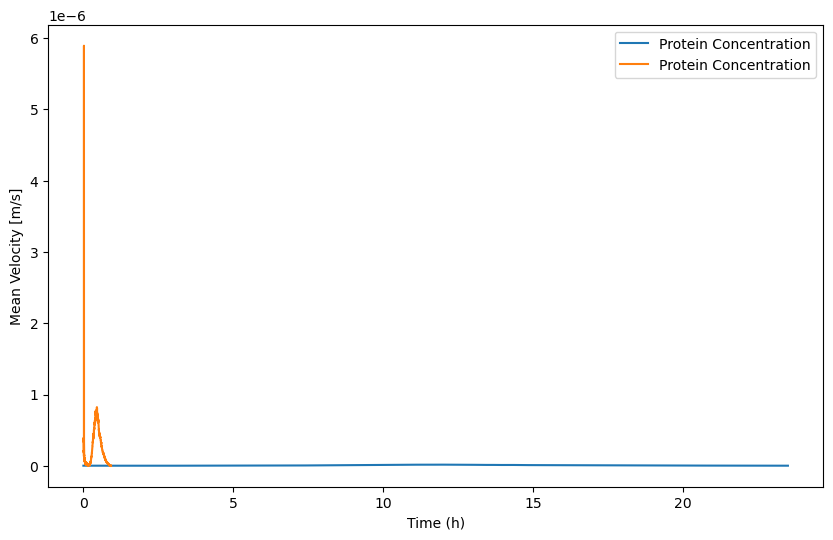

In [41]:
# now let's plot protein_concentration vs time_sec
plt.figure(figsize=(10, 6))
plt.plot(k401['time_h'], k401['velocity magnitude [m/s]_mean'], label='Protein Concentration')
plt.plot(kif3['time_h']/20, kif3['velocity magnitude [m/s]_mean'], label='Protein Concentration')

plt.xlabel('Time (h)')
plt.ylabel('Mean Velocity [m/s]')
#plot in log scale
# plt.yscale('log')
plt.legend()
plt.show()

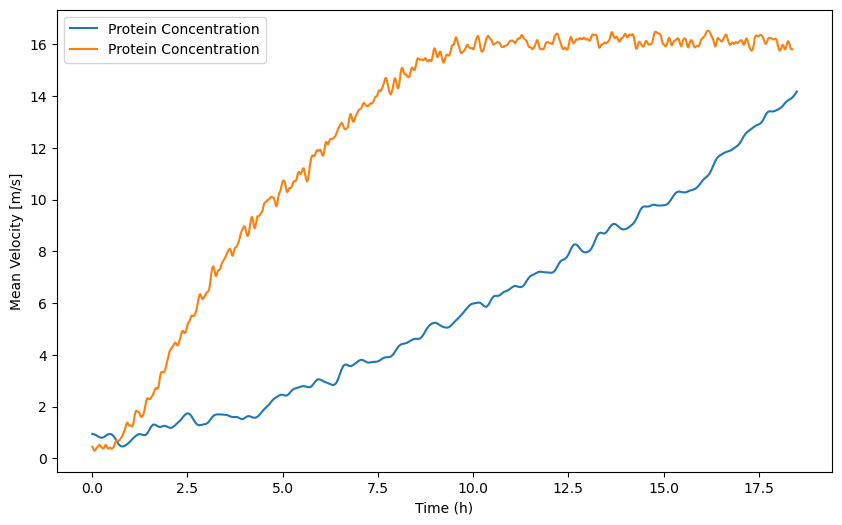

In [42]:
# now let's plot protein_concentration vs time_sec
plt.figure(figsize=(10, 6))
plt.plot(k401['time_h'][:-100], k401['Concentration'][:-100], label='Protein Concentration')
plt.plot(kif3['time_h'], kif3['Concentration'], label='Protein Concentration')

plt.xlabel('Time (h)')
plt.ylabel('Mean Velocity [m/s]')

plt.legend()
plt.show()

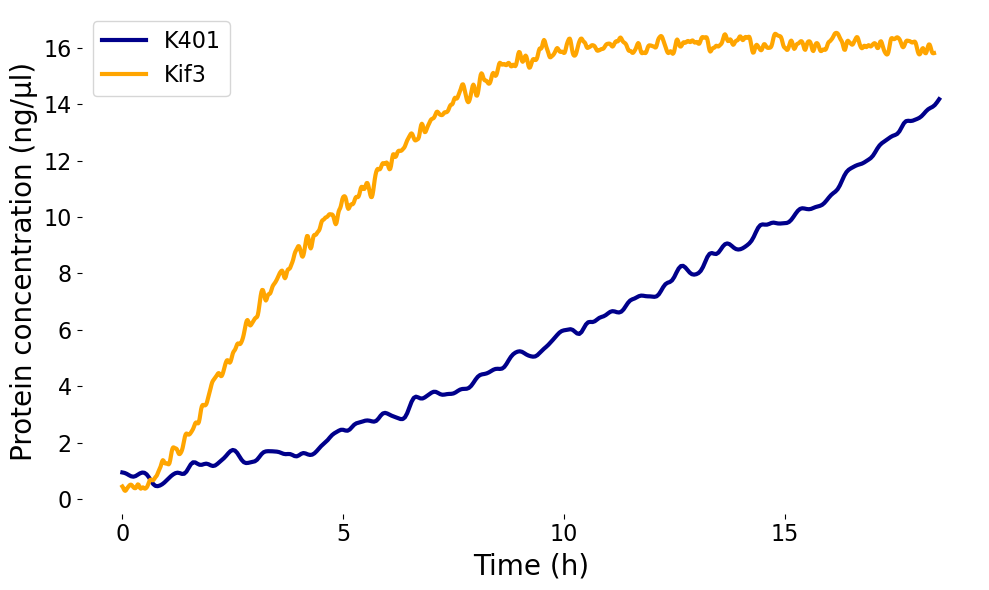

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Setting font sizes for various elements
label_font_size = 20  # Font size for axis labels
tick_font_size = 16   # Font size for tick labels
legend_font_size = 16  # Font size for legend

# Setup the plot
plt.figure(figsize=(10, 6))

# Plotting k401 data in dark blue
plt.plot(k401['time_h'][:-100], k401['Concentration'][:-100], label='K401', color='darkblue', linewidth=3)

# Plotting kif3 data in orange and scaling the time by factor of 20
plt.plot(kif3['time_h'], kif3['Concentration'], label='Kif3', color='orange', linewidth=3)

# Setting labels with larger font sizes
plt.xlabel('Time (h)', fontsize=label_font_size)
plt.ylabel('Protein concentration (ng/µl)', fontsize=label_font_size)

# Setting the y-axis to logarithmic scale
# plt.yscale('log')

# Adding a legend with specified font size
plt.legend(fontsize=legend_font_size)

# Setting larger tick labels
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# Applying a locator to limit the number of ticks on the x-axis for clarity
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

# Optionally, hide the right and top spines to make it look cleaner
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# save the plot as a png file
plt.savefig('protein_concentration_vs_time.png', dpi=500)

# Show plot with tight layout to ensure no clipping
plt.tight_layout()
plt.show()


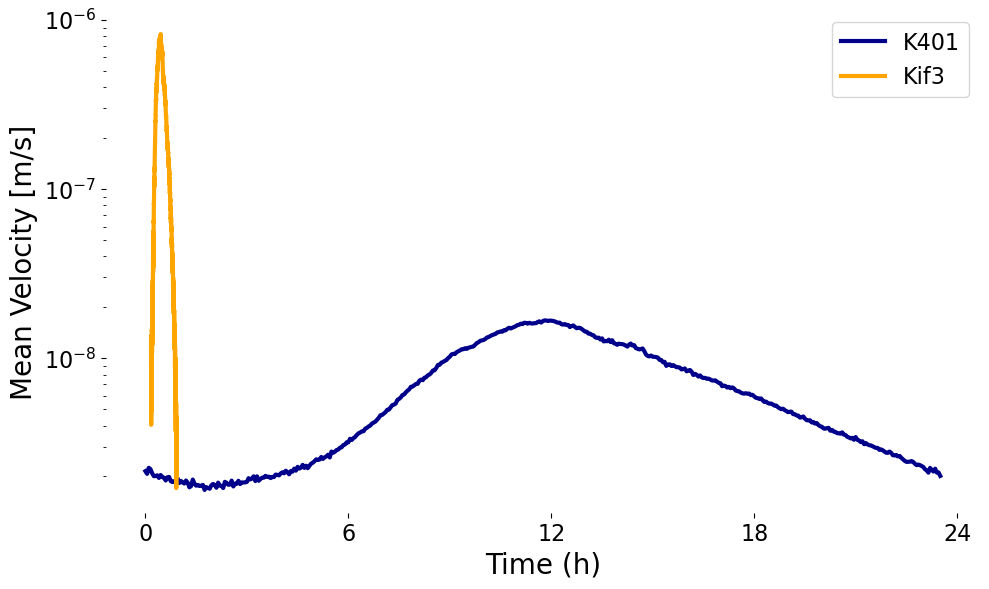

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Setting font sizes for various elements
label_font_size = 20  # Font size for axis labels
tick_font_size = 16   # Font size for tick labels
legend_font_size = 16  # Font size for legend

# Setup the plot
plt.figure(figsize=(10, 6))

# Plotting k401 data in dark blue
plt.plot(k401['time_h'], k401['velocity magnitude [m/s]_mean'], label='K401', color='darkblue', linewidth=3)

# Plotting kif3 data in orange and scaling the time by factor of 20
plt.plot(kif3['time_h'][200:]/20, kif3['velocity magnitude [m/s]_mean'][200:], label='Kif3', color='orange', linewidth=3)

# Setting labels with larger font sizes
plt.xlabel('Time (h)', fontsize=label_font_size)
plt.ylabel('Mean Velocity [m/s]', fontsize=label_font_size)

# Setting the y-axis to logarithmic scale
plt.yscale('log')

# Adding a legend with specified font size
plt.legend(fontsize=legend_font_size)

# Setting larger tick labels
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# Applying a locator to limit the number of ticks on the x-axis for clarity
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

# Optionally, hide the right and top spines to make it look cleaner
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# save the plot as a png file
plt.savefig('logvelocity_vs_time.png', dpi=500)


# Show plot with tight layout to ensure no clipping
plt.tight_layout()
plt.show()


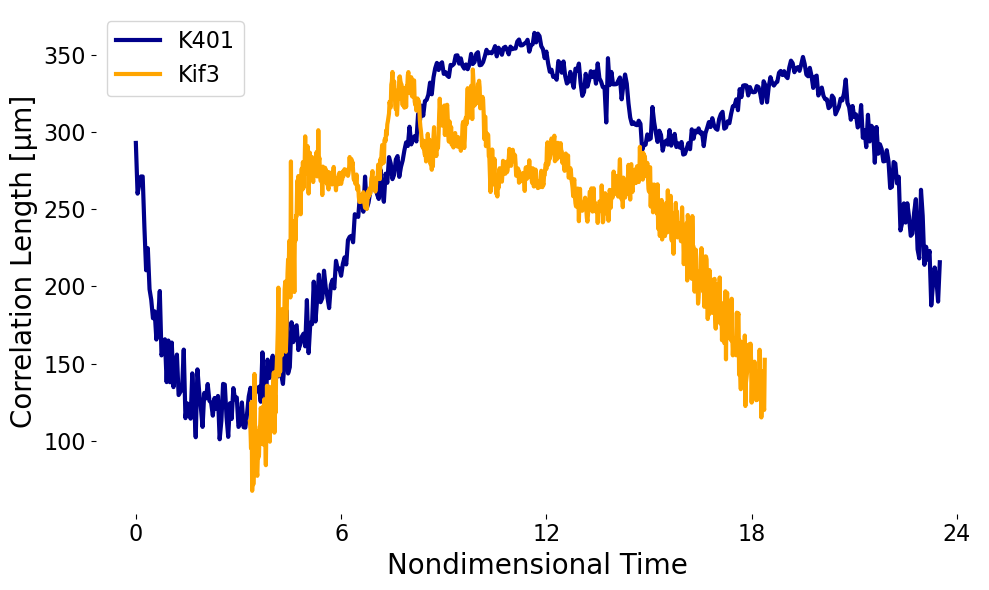

In [58]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Setting font sizes for various elements
label_font_size = 20  # Font size for axis labels
tick_font_size = 16   # Font size for tick labels
legend_font_size = 16  # Font size for legend

# Setup the plot
plt.figure(figsize=(10, 6))

# Plotting k401 data in dark blue
plt.plot(k401['time_h'], k401['correlation length [m]_mean'] * 1000000, label='K401', color='darkblue', linewidth=3)

# Plotting kif3 data in orange and scaling the time by factor of 20
plt.plot(kif3['time_h'][200:], kif3['correlation length [m]_mean'][200:] * 1000000, label='Kif3', color='orange', linewidth=3)

# Setting labels with larger font sizes
plt.xlabel('Nondimensional Time', fontsize=label_font_size)
plt.ylabel('Correlation Length [µm]', fontsize=label_font_size)

# Setting the y-axis to logarithmic scale
# plt.yscale('log')

# Adding a legend with specified font size
plt.legend(fontsize=legend_font_size)

# Setting larger tick labels
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# Applying a locator to limit the number of ticks on the x-axis for clarity
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

# Optionally, hide the right and top spines to make it look cleaner
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# save the plot as a png file
# plt.savefig('logvelocity_vs_time.png', dpi=500)


# Show plot with tight layout to ensure no clipping
plt.tight_layout()
plt.show()


In [51]:
k401.columns

Index(['frame', 'x [m]_mean', 'y [m]_mean', 'u [m/s]_mean', 'v [m/s]_mean',
       'data type [-]_mean', 'vorticity [1/s]_mean',
       'velocity magnitude [m/s]_mean', 'divergence [1/s]_mean',
       'dcev [1]_mean', 'shear [1/s]_mean', 'strain [1/s]_mean',
       'vector direction [degrees]_mean', 'correlation length [m]_mean',
       'power [W]_mean', 'Intensity', 'Concentration',
       'Condition_Subcondition', 'work [J]', 'time_sec', 'time_min', 'time_h',
       'smoothed_concentration', 'total_molecules'],
      dtype='object')

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator

# # Avogadro's number
# N_A = 6.022e23

# # Molecular weights in kDa
# M_k401 = 85  # kDa for K401
# M_kif3 = 95  # kDa for Kif3

# # Reaction volume in µL converted to liters
# volume_l = 2e-6  # liters

# # Convert ng/µL to nM
# k401['concentration_nM'] = (k401['Concentration'] * 1e6) / (M_k401 * 1e3) / N_A / volume_l * 1e9
# kif3['concentration_nM'] = (kif3['Concentration'] * 1e6) / (M_kif3 * 1e3) / N_A / volume_l * 1e9

# # Setting font sizes for various elements
# label_font_size = 20  # Font size for axis labels
# tick_font_size = 16   # Font size for tick labels
# legend_font_size = 16  # Font size for legend

# # Setup the plot
# plt.figure(figsize=(10, 6))

# # Plotting k401 data in dark blue
# plt.plot(k401['time_h'][:-105], k401['concentration_nM'][:-105], label='K401', color='darkblue', linewidth=3)

# # Plotting kif3 data in orange
# plt.plot(kif3['time_h'], kif3['concentration_nM'], label='Kif3', color='orange', linewidth=3)

# # Setting labels with larger font sizes
# plt.xlabel('Time (h)', fontsize=label_font_size)
# plt.ylabel('Concentration (nM)', fontsize=label_font_size)

# # Adding a legend with specified font size
# plt.legend(fontsize=legend_font_size)

# # Setting larger tick labels
# plt.xticks(fontsize=tick_font_size)
# plt.yticks(fontsize=tick_font_size)

# # Applying a locator to limit the number of ticks on the x-axis for clarity
# plt.gca().xaxis.set_major_locator(MaxNLocator(5))

# # Hide all spines to make it look cleaner
# for spine in plt.gca().spines.values():
#     spine.set_visible(False)

# # Show plot with tight layout to ensure no clipping
# plt.tight_layout()
# plt.show()


In [ ]:
# now let's plot protein_concentration vs time_sec
plt.figure(figsize=(10, 6))
plt.plot(df_merged['time_h'], df_merged['velocity magnitude [m/s]_mean'], label='Protein Concentration')
plt.xlabel('Time (h)')
plt.ylabel('Protein Concentration')
plt.legend()
plt.show()

In [ ]:
# now plot protein_concentration vs velocity_magnitude
plt.figure(figsize=(10, 6))
plt.scatter( df_merged['Concentration'], df_merged['velocity magnitude [m/s]_mean'])
plt.ylabel('Velocity Magnitude (um/s)')
plt.xlabel('Protein Concentration')
plt.show()

In [ ]:
# now plot protein_concentration vs velocity_magnitude
plt.figure(figsize=(10, 6))
plt.scatter( df_merged['Concentration'], df_merged['work [J]'])
plt.xlabel('Concentration')
plt.ylabel('work [J]')
plt.show()

In [ ]:
# now plot protein_concentration vs velocity_magnitude
plt.figure(figsize=(10, 6))
plt.scatter( df_merged['work [J]'], df_merged['Concentration'] )
plt.xlabel('Velocity Magnitude (um/s)')
plt.ylabel('Protein Concentration')
plt.show()

In [ ]:
# create 3d plot with time, protein concentration and velocity magnitude
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_merged['time_sec'], df_merged['Concentration'], df_merged['velocity magnitude [m/s]_mean'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Protein Concentration')
ax.set_zlabel('Velocity Magnitude (m/s)')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume df_merged is already defined and has the columns: 'time_sec', 'Concentration', and 'velocity magnitude [m/s]_mean'

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_merged['time_h'], df_merged['velocity magnitude [m/s]_mean'], df_merged['Concentration'], )

ax.set_xlabel('Time (h)')
ax.set_ylabel('Protein Concentration')
ax.set_zlabel('Velocity Magnitude (m/s)')

# Manually adjust the margins or viewing angle if needed
ax.view_init(elev=20, azim=-45)  # Adjust the viewing angle for better visibility of labels

# Adjust layout to make space for labels
plt.tight_layout()  # This can help ensure that the labels don't get cut off

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

# Assuming df_merged is already loaded and contains 'time_sec', 'Concentration', and 'velocity magnitude [m/s]_mean'

# Applying a Gaussian filter with sigma = 2 to the data for smoothing
smoothed_concentration = gaussian_filter1d(df_merged['Concentration'], sigma=10)
smoothed_velocity = gaussian_filter1d(df_merged['velocity magnitude [m/s]_mean'], sigma=2)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Settings for larger fonts
label_font_size = 20  # Font size for labels
title_font_size = 20  # Font size for titles
tick_font_size = 16   # Font size for tick labels

# Plotting protein concentration
color = 'darkblue'  # Color for protein concentration
ax1.set_xlabel('Time (hours)', fontsize=label_font_size)
ax1.set_ylabel('Protein Concentration [ng/µl]', color=color, fontsize=label_font_size)
ax1.plot(df_merged['time_sec'] / 3600, smoothed_concentration, color=color, linewidth=3)  # Thicker line with Gaussian smoothing
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
ax1.tick_params(axis='x', labelsize=tick_font_size)  # Set font size for x-axis tick labels
ax1.xaxis.set_major_locator(MaxNLocator(5))  # Limit the number of x-axis ticks to 5
ax1.yaxis.set_major_locator(MaxNLocator(4))  # Limit the number of y-axis ticks to 5

# Setting spines to be invisible or a lighter color
for spine in ax1.spines.values():
    spine.set_visible(False)  # Make spines invisible

# Creating a second y-axis for velocity magnitude
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'black'  # Dark red color for velocity magnitude
ax2.set_ylabel('Velocity Magnitude (nm/s)', color=color, fontsize=label_font_size)
ax2.plot(df_merged['time_sec'] / 3600, smoothed_velocity * 1E9, color=color, linewidth=3)  # Thicker line with Gaussian smoothing
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_font_size)
ax2.yaxis.set_major_locator(MaxNLocator(4))  # Limit the number of y-axis ticks to 5

# Optionally, also adjust the spines for ax2 if needed
for spine in ax2.spines.values():
    spine.set_visible(False)  # Make spines invisible

fig.tight_layout()  # Adjust layout to make sure everything fits and labels are not clipped

# Save the figure with 300 dpi
plt.savefig('plot.png', dpi=500)
plt.show()


In [ ]:
df_merged.columns

In [ ]:
# now let's plot protein_concentration vs time in hours, adding a second y axis for the velocity magnitude
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Protein Concentration', color=color)
ax1.plot(df_merged['time_sec'] / 3600, df_merged['Concentration'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Velocity Magnitude (m/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_merged['time_sec'] / 3600, df_merged['correlation length [m]_mean'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()